In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10 as mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [2]:
#import os
#os.environ['path'] += r';C:\Program Files (x86)\Graphviz2.38\bin;'

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 image_size,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test.flatten())
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    if len(image_size) == 3:
        figure = np.zeros((image_size[0] * n, image_size[1] * n, image_size[2]))
    else:
        figure = np.zeros((image_size[0] * n, image_size[1] * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(*image_size)
            figure[i * image_size[0]: (i + 1) * image_size[0],
                   j * image_size[1]: (j + 1) * image_size[1]] = digit

    plt.figure(figsize=(10, 10))
    start_range = image_size[0] // 2
    end_range = (n - 1) * image_size[0] + start_range + 1
    pixel_range = np.arange(start_range, end_range, image_size[0])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    if len(image_size) == 3 and image_size[-1] == 3:
        plt.imshow(figure)
    else:
        plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape

(50000, 32, 32, 3)

/Users/ecrespo/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[6]')

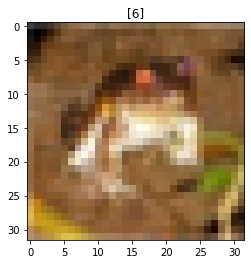

In [6]:
plt.imshow(x_train[0])
plt.title(y_train[0])

In [7]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1:]
original_dim = np.prod(image_size)
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [8]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 3072)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1573376     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

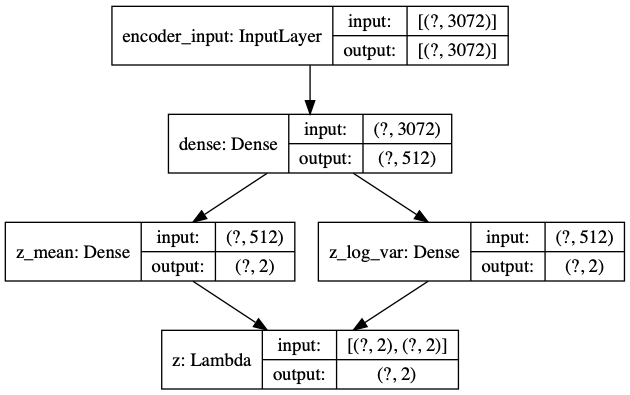

In [9]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              1575936   
Total params: 1,577,472
Trainable params: 1,577,472
Non-trainable params: 0
_________________________________________________________________


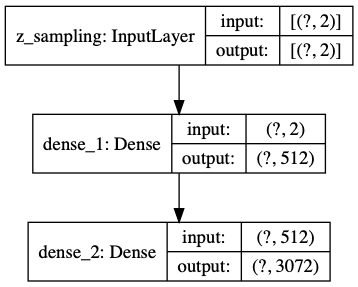

In [10]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

In [11]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [12]:

args = {'mse': False,    # Use mse loss instead of binary cross entropy (default) 
        'weights': ""}   # Load h5 model trained weights when a path is given


Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 3072)]       0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 1575428     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 3072)         1577472     encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_clip_by_value/Minim [(None, 3072)]       0           decoder[1][0]                    
____________________________________________________________________________________________

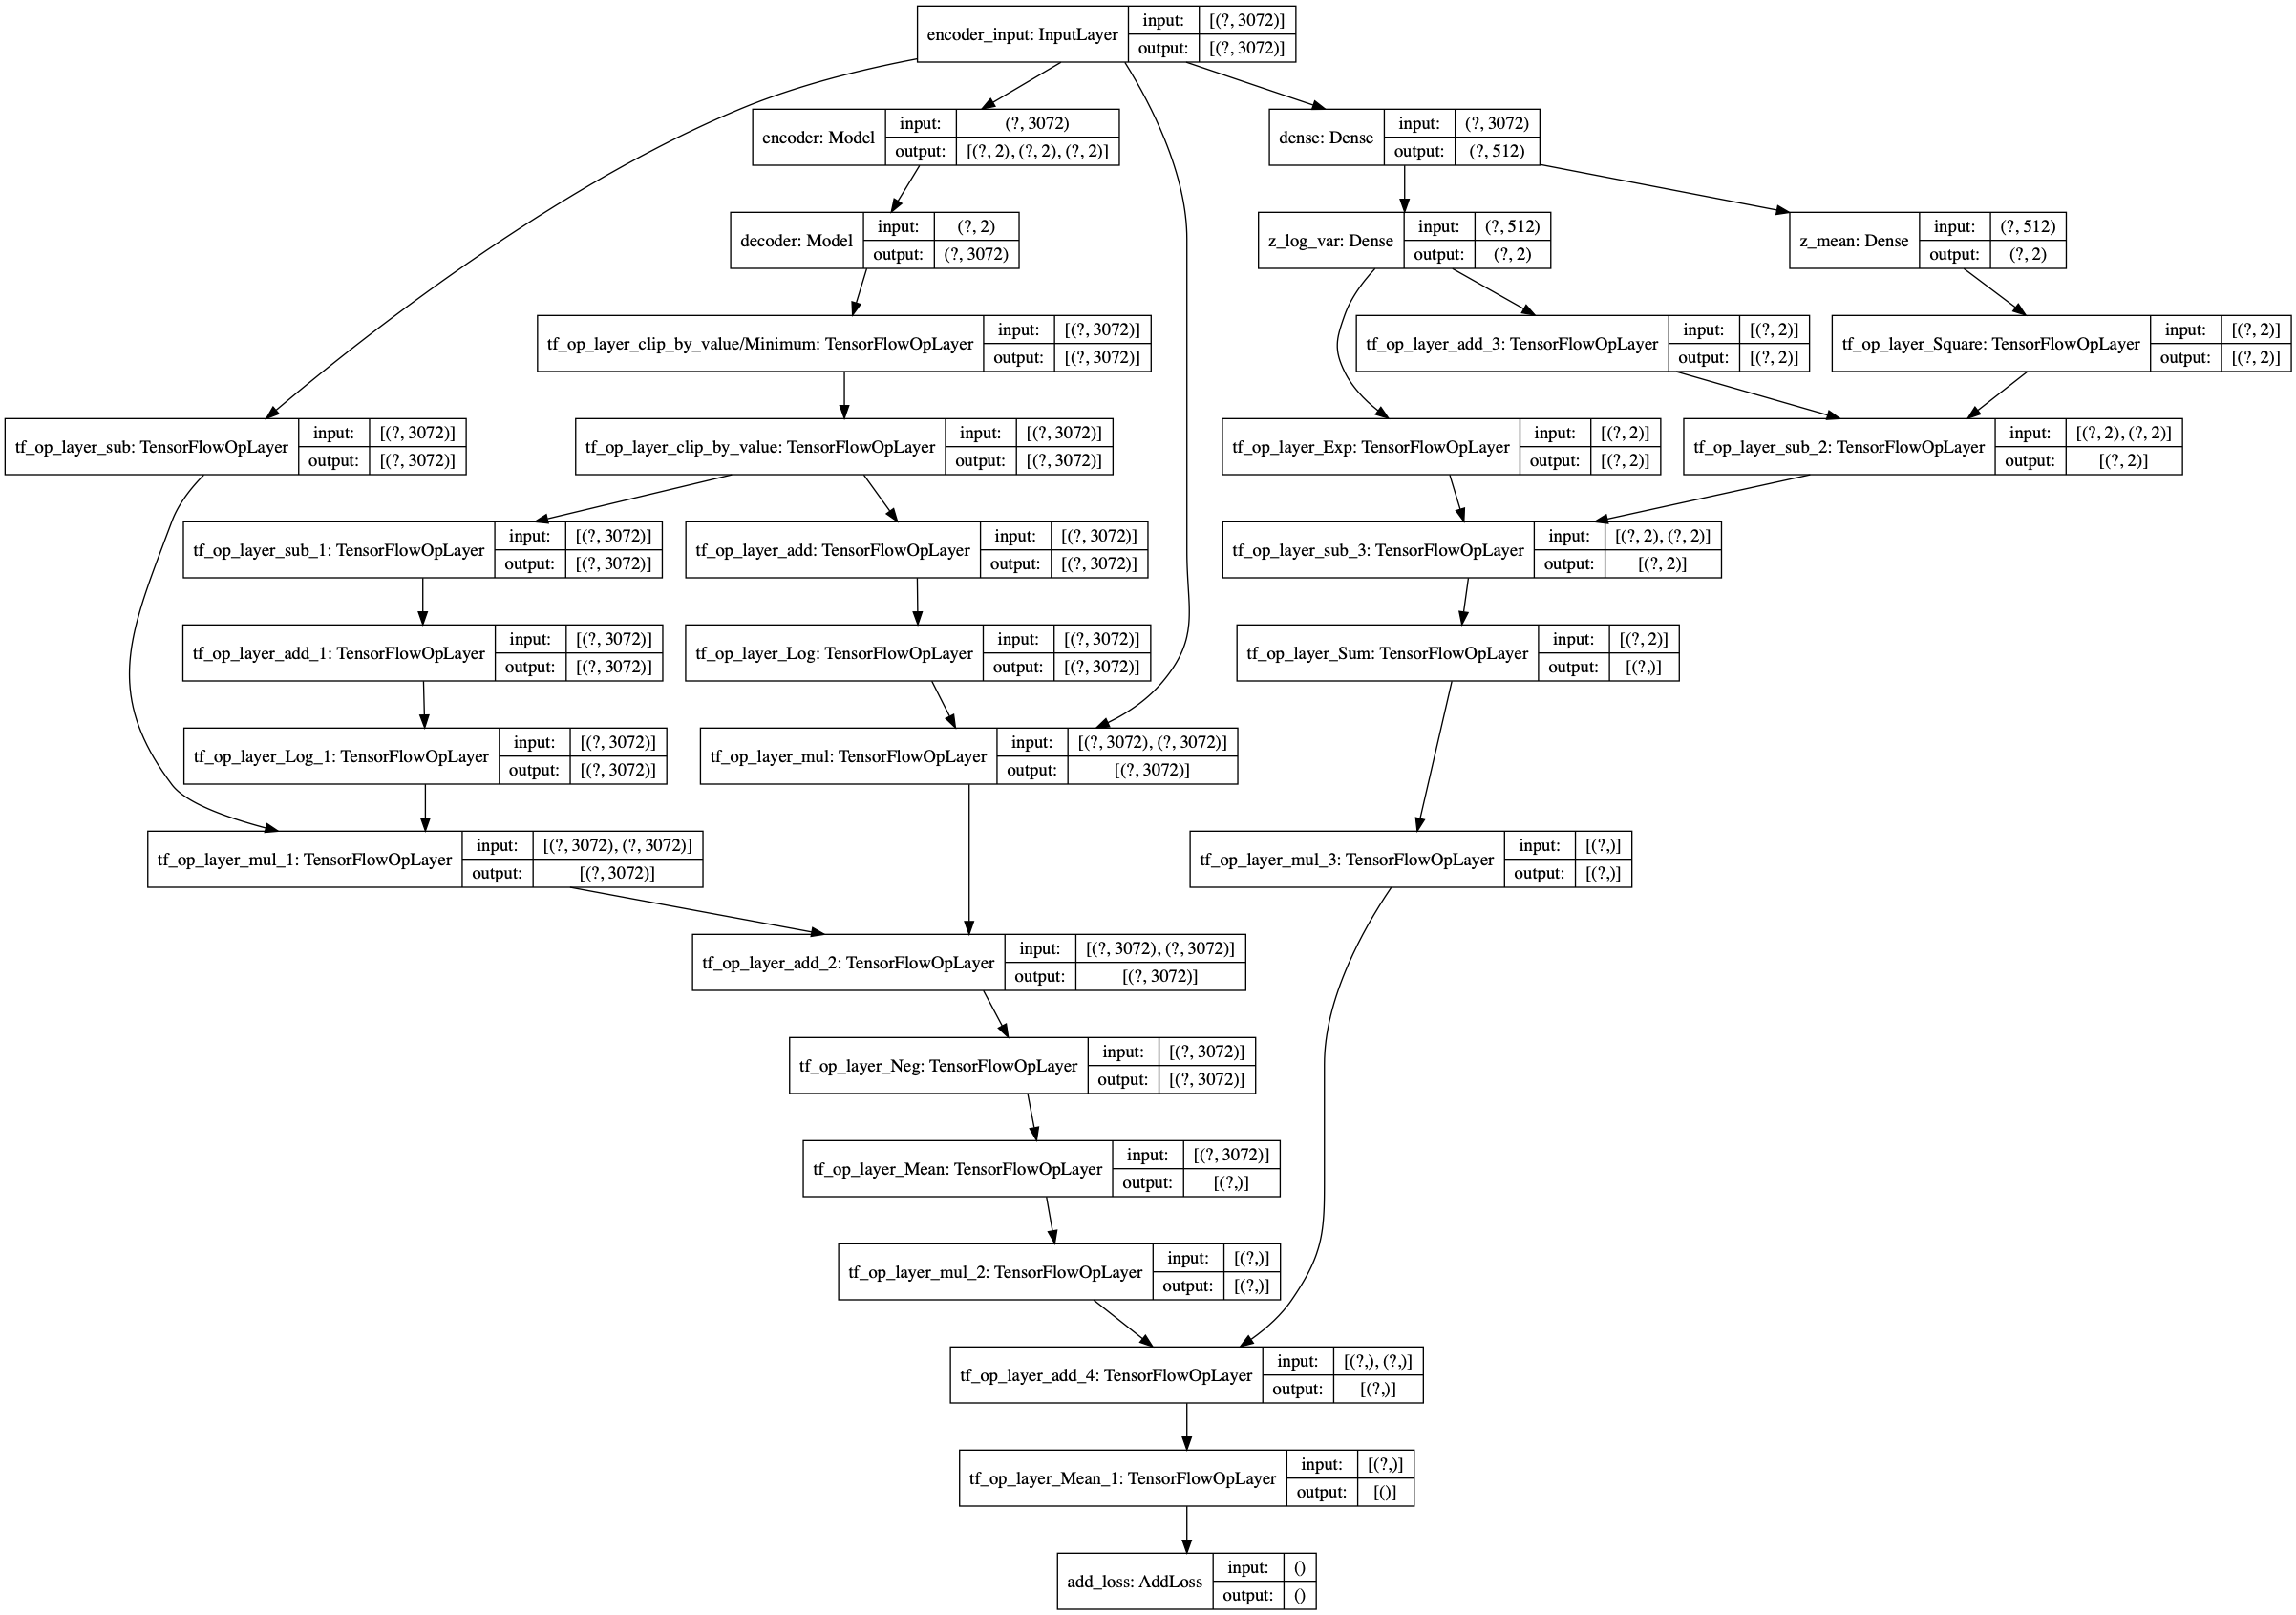

In [13]:
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
if args['mse']:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

In [14]:
if args['weights']:
    vae.load_weights(args['weights'])
else:
    # train the autoencoder
    fit_history = vae.fit(x_train,
            epochs=20, #reduzco a 20 para que sea más rápido
            batch_size=batch_size,
            validation_data=(x_test, None),
            validation_steps=len(x_test)//batch_size)
    vae.save_weights('vae_mlp_cifar.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 22s 431us/sample - loss: 1995.1939 - val_loss: 1961.4257
Epoch 2/20
50000/50000 [==============================] - 26s 529us/sample - loss: 1962.2268 - val_loss: 1959.5950
Epoch 3/20
50000/50000 [==============================] - 26s 526us/sample - loss: 1960.4370 - val_loss: 1958.5246
Epoch 4/20
50000/50000 [==============================] - 32s 639us/sample - loss: 1959.5094 - val_loss: 1957.6775
Epoch 5/20
50000/50000 [==============================] - 24s 474us/sample - loss: 1958.6101 - val_loss: 1958.4220
Epoch 6/20
50000/50000 [==============================] - 24s 479us/sample - loss: 1958.3005 - val_loss: 1956.6358
Epoch 7/20
50000/50000 [==============================] - 24s 483us/sample - loss: 1957.5662 - val_loss: 1958.6611
Epoch 8/20
50000/50000 [==============================] - 20s 407us/sample - loss: 1957.2682 - val_loss: 1956.4587
Epoch 9/20
50000/50000 [======

ValueError: Unable to create group (name already exists)

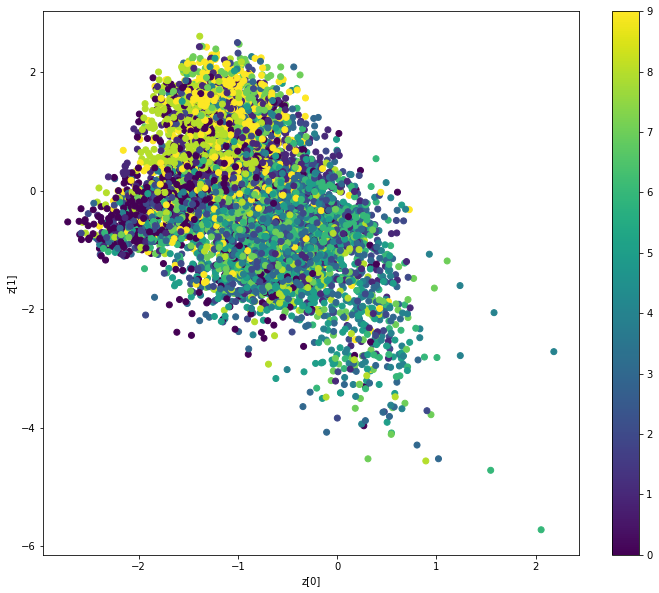

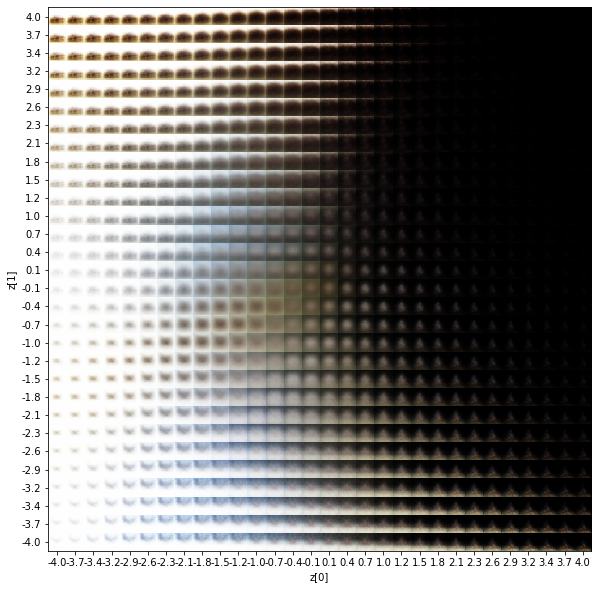

In [15]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp",
             image_size=image_size)

In [17]:
fit_history.history

{'loss': [1995.193889765625,
  1962.226814296875,
  1960.4369593359374,
  1959.509401015625,
  1958.610072578125,
  1958.300535234375,
  1957.566212578125,
  1957.2682453515624,
  1956.9532021875,
  1956.5394593359374,
  1956.051525234375,
  1955.2771262109375,
  1955.232436796875,
  1954.5915394140625,
  1953.894103046875,
  1953.1077446875,
  1952.473666484375,
  1951.7563752734375,
  1950.9944527734374,
  1950.8179653125],
 'val_loss': [1961.4256546875,
  1959.5949875,
  1958.5246265625,
  1957.6774515625,
  1958.42198125,
  1956.6357828125,
  1958.66110625,
  1956.458690625,
  1955.173125,
  1954.966484375,
  1954.5689875,
  1953.7871046875,
  1953.7391140625,
  1954.4312421875,
  1953.62315625,
  1951.2785453125,
  1952.9170046875,
  1950.414078125,
  1950.5568546875,
  1949.9580234375]}

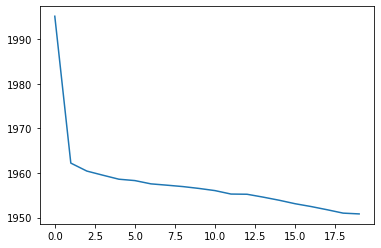

In [21]:
plt.figure()
plt.plot(fit_history.history['loss'])

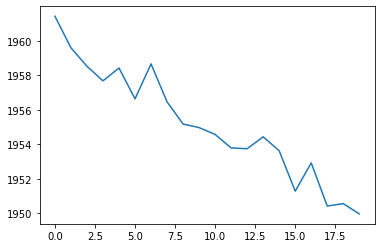

In [22]:
plt.figure()
plt.plot(fit_history.history['val_loss'])